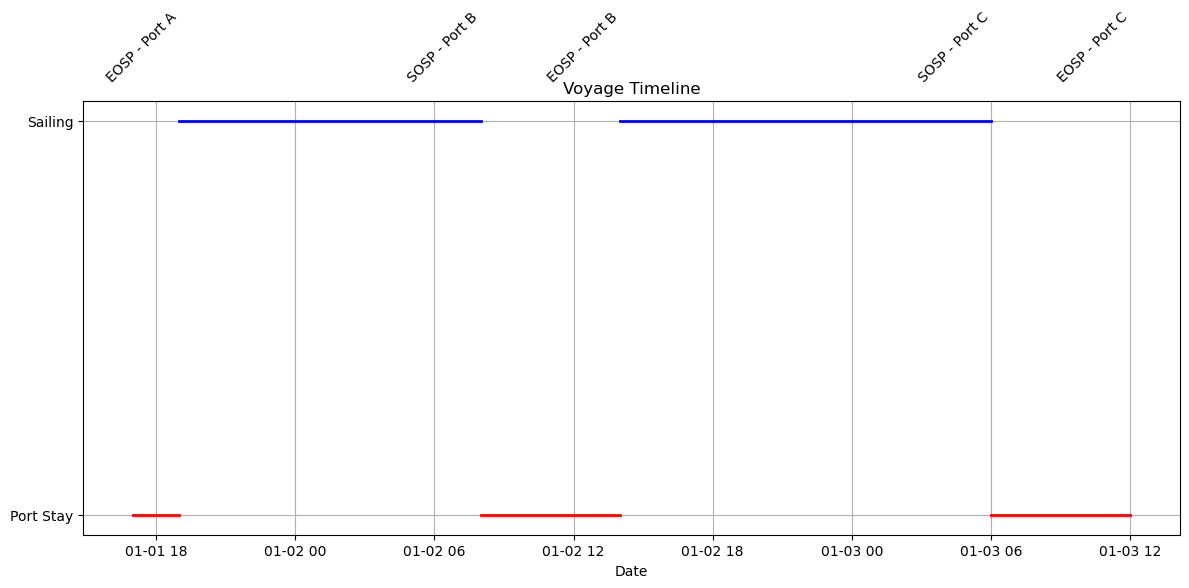

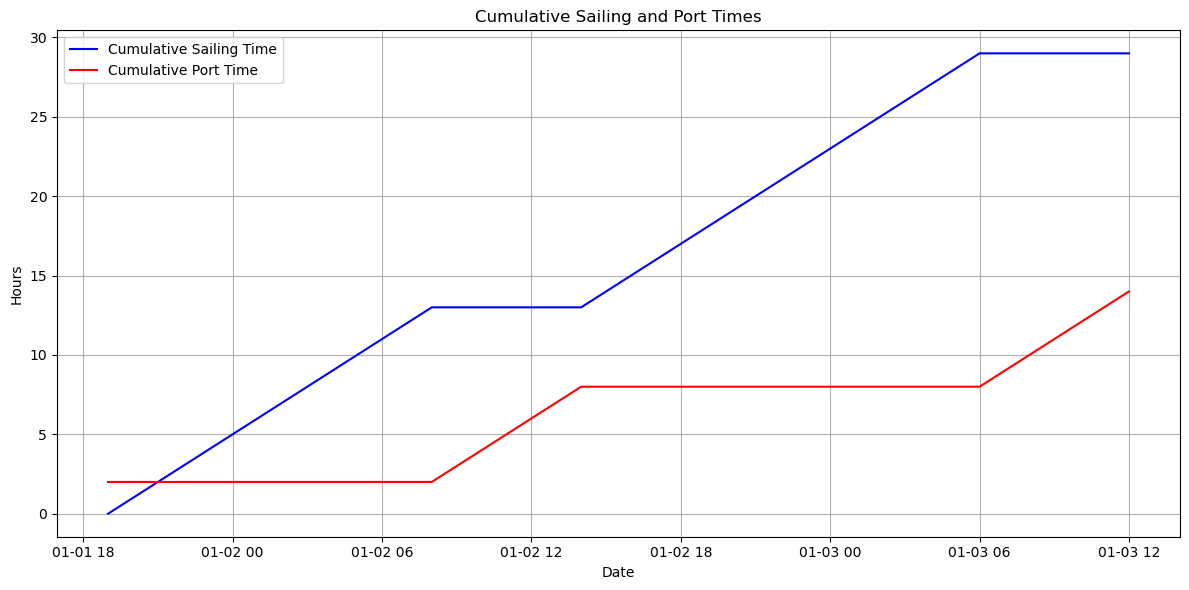

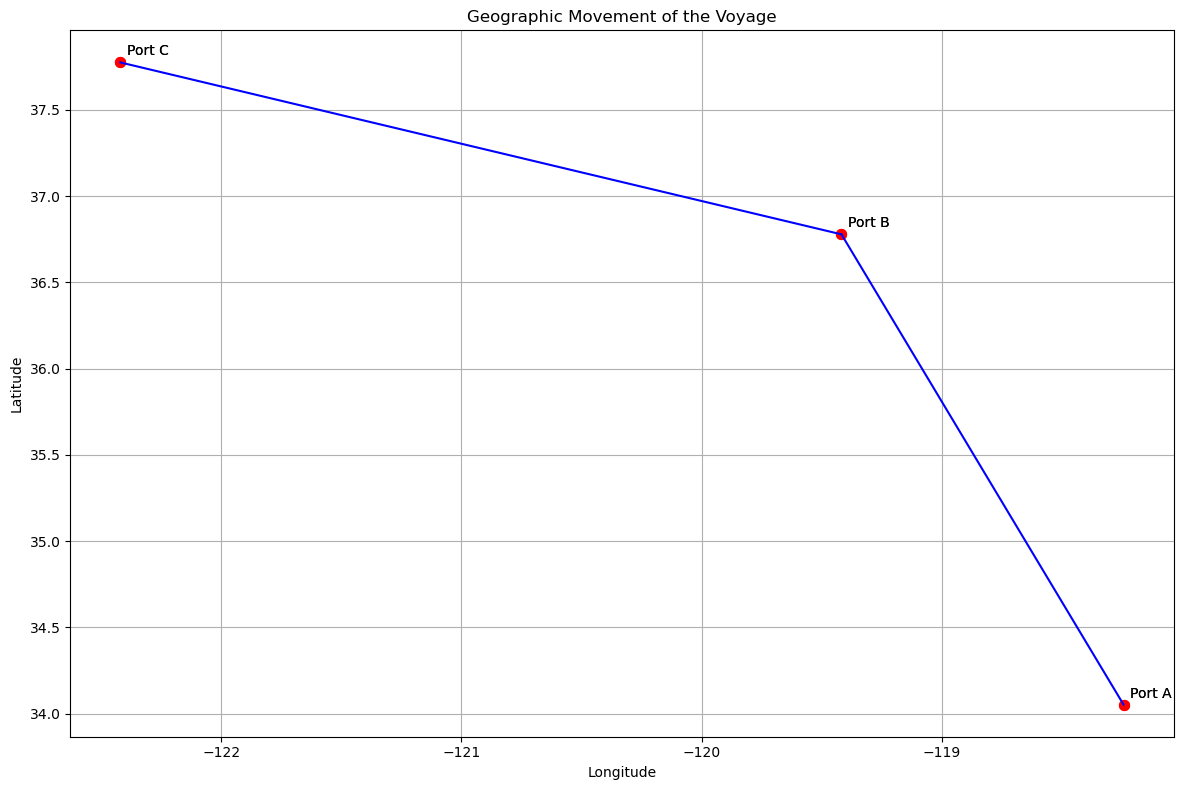

   id event             event_datetime voyage_From      lat       lon  \
0   1  SOSP 2020-01-01 16:59:59.971200      Port A  34.0522 -118.2437   
1   2  EOSP 2020-01-01 19:00:00.028800      Port A  34.0522 -118.2437   
2   3  SOSP 2020-01-02 07:59:59.971200      Port B  36.7783 -119.4179   
3   4  EOSP 2020-01-02 13:59:59.971200      Port B  36.7783 -119.4179   
4   5  SOSP 2020-01-03 06:00:00.000000      Port C  37.7749 -122.4194   
5   6  EOSP 2020-01-03 12:00:00.000000      Port C  37.7749 -122.4194   

  segment_type   duration  distance_travelled  cumulative_sailing_time  \
0      Unknown        NaN            0.000000                      NaN   
1    Port Stay   2.000016            0.000000                 0.000000   
2      Sailing  12.999984          173.463048                12.999984   
3    Port Stay   6.000000            0.000000                12.999984   
4      Sailing  16.000008          155.371267                28.999992   
5    Port Stay   6.000000            0.00000

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3440.065  # Earth's radius in nautical miles
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c

# Sample data (replace this with actual data loading from a database)
data = [
    {'id': 1, 'event': 'SOSP', 'dateStamp': 43831, 'timeStamp': 0.708333, 'voyage_From': 'Port A', 'lat': 34.0522, 'lon': -118.2437, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 2, 'event': 'EOSP', 'dateStamp': 43831, 'timeStamp': 0.791667, 'voyage_From': 'Port A', 'lat': 34.0522, 'lon': -118.2437, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 3, 'event': 'SOSP', 'dateStamp': 43832, 'timeStamp': 0.333333, 'voyage_From': 'Port B', 'lat': 36.7783, 'lon': -119.4179, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 4, 'event': 'EOSP', 'dateStamp': 43832, 'timeStamp': 0.583333, 'voyage_From': 'Port B', 'lat': 36.7783, 'lon': -119.4179, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 5, 'event': 'SOSP', 'dateStamp': 43833, 'timeStamp': 0.25, 'voyage_From': 'Port C', 'lat': 37.7749, 'lon': -122.4194, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 6, 'event': 'EOSP', 'dateStamp': 43833, 'timeStamp': 0.5, 'voyage_From': 'Port C', 'lat': 37.7749, 'lon': -122.4194, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None}
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Filter data
df = df[(df['imo_num'] == '9434761') & (df['voyage_Id'] == '6') & (df['allocatedVoyageId'].isnull())]

# Calculate event_datetime
df['event_datetime'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df['dateStamp'] + df['timeStamp'], unit='D')

# Sort by event_datetime
df = df.sort_values('event_datetime')

# Calculate previous event information
df['prev_event_datetime'] = df['event_datetime'].shift()
df['prev_lat'] = df['lat'].shift()
df['prev_lon'] = df['lon'].shift()
df['prev_event'] = df['event'].shift()
df['prev_port'] = df['voyage_From'].shift()

# Identify voyage segments
df['segment_type'] = 'Unknown'
for i in range(1, len(df)):
    if df.iloc[i-1]['event'] == 'SOSP' and df.iloc[i]['event'] == 'EOSP' and df.iloc[i-1]['voyage_From'] == df.iloc[i]['voyage_From']:
        df.iloc[i, df.columns.get_loc('segment_type')] = 'Port Stay'
    elif df.iloc[i-1]['event'] == 'EOSP' and df.iloc[i]['event'] == 'SOSP' and df.iloc[i-1]['voyage_From'] != df.iloc[i]['voyage_From']:
        df.iloc[i, df.columns.get_loc('segment_type')] = 'Sailing'

# Calculate duration
df['duration'] = (df['event_datetime'] - df['prev_event_datetime']).dt.total_seconds() / 3600  # in hours

# Calculate distance travelled
df['distance_travelled'] = df.apply(lambda row: 
    haversine_distance(row['prev_lat'], row['prev_lon'], row['lat'], row['lon'])
    if row['segment_type'] == 'Sailing'
    else 0, axis=1)

# Calculate cumulative times
df['cumulative_sailing_time'] = (df['duration'] * (df['segment_type'] == 'Sailing')).cumsum()
df['cumulative_port_time'] = (df['duration'] * (df['segment_type'] == 'Port Stay')).cumsum()

# Visualize the voyage timeline
plt.figure(figsize=(12, 6))
for i in range(1, len(df)):
    start_time = df.iloc[i-1]['event_datetime']
    end_time = df.iloc[i]['event_datetime']
    segment_type = df.iloc[i]['segment_type']
    if segment_type == 'Sailing':
        plt.plot([start_time, end_time], [1, 1], 'b-', linewidth=2)
    elif segment_type == 'Port Stay':
        plt.plot([start_time, end_time], [0, 0], 'r-', linewidth=2)
    plt.text(end_time, 1.1, f"{df.iloc[i]['event']} - {df.iloc[i]['voyage_From']}", rotation=45, ha='right')

plt.yticks([0, 1], ['Port Stay', 'Sailing'])
plt.xlabel('Date')
plt.title('Voyage Timeline')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative times
plt.figure(figsize=(12, 6))
plt.plot(df['event_datetime'], df['cumulative_sailing_time'], 'b-', label='Cumulative Sailing Time')
plt.plot(df['event_datetime'], df['cumulative_port_time'], 'r-', label='Cumulative Port Time')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.title('Cumulative Sailing and Port Times')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot geographic movement
plt.figure(figsize=(12, 8))
plt.scatter(df['lon'], df['lat'], c='red', s=50)
for i, row in df.iterrows():
    plt.annotate(row['voyage_From'], (row['lon'], row['lat']), xytext=(5, 5), textcoords='offset points')

for i in range(1, len(df)):
    if df.iloc[i]['segment_type'] == 'Sailing':
        plt.plot([df.iloc[i-1]['lon'], df.iloc[i]['lon']], [df.iloc[i-1]['lat'], df.iloc[i]['lat']], 'b-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Movement of the Voyage')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display results
print(df[['id', 'event', 'event_datetime', 'voyage_From', 'lat', 'lon', 'segment_type', 'duration', 'distance_travelled', 'cumulative_sailing_time', 'cumulative_port_time']])